# Example 2: Jacobi method

This is a notebook demonstrating how to use Cython and [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) to accelerate Python code.

## Jacobi method - background

The problem considered in this notebook is solving the [2-dimensional heat equation](https://en.wikipedia.org/wiki/Heat_equation) using the Jacobi method.

This mathematical equation can be used, for example, to predict how the temperature in a square metal plate will change when it is subjected to heating on one of its sides.

Consider that the plate is approximated by a square "grid" of points. A 2-dimensional array $T^n$ is used to store the initial known temperatures at those points. Each Jacobi iteration computes an updated array of temperatures $T^{n+1}$ according to the following update scheme:

$ T^{n+1}[i, j] = (T^n[i-1, j] + T^n[i+1, j] + T^n[i, j-1] + T^n[i, j+1]) / 4 $

That is, the temperature at each grid point receives equal influence from each of its 4 "neighbouring" grid points,. Therefore it is updated as the average of those temperatures. This process is repeated until "convergence" is reached, i.e., the values from two successive iterations do not differ significantly.

You will notice that the update is impossible to perform at the "boundary" grid points, i.e., the edges of the plate. There are many ways to treat boundaries, but in this simple example, we will simply assume that their temperature doesn't change (fixed or [_Dirichlet_](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) boundary condition).

## Setup

In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import format_time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
def generate_data(size):
    """
    Generate the initial temperature distribution.
    """
    data = np.zeros((size, size), dtype="float32")
    
    # apply heating to one side of the square:
    data[:, 0] = np.sin(np.pi * np.arange(size) / size)
    return data

def time_jacobi(data, jacobi_solver):
    """
    Given a jacobi solver and some initial data,
    return the average time taken by the solver to
    perform one Jacobi iteration.
    """
    jacobi_solver(data, max_diff=1e-5, max_iter=1)  # warmup    
    start = timeit.default_timer()
    iters = jacobi_solver(data, max_diff=1e-5, max_iter=1000)
    end = timeit.default_timer()
    time_per_iter = (end - start) / iters    
    return time_per_iter

def surface_plot(data, ax=None):
    """
    Visualize the given data with a surface plot.
    """
    M, N = data.shape
    fig = plt.figure(figsize=(10, 10))
    if ax is None:
        ax = fig.gca(projection='3d')
    ax.w_xaxis.set_pane_color((0.5, 0.5, 0.5, 0.5))
    x, y = np.meshgrid(np.linspace(0, 1, M), np.linspace(0, 1, N))
    ax.plot_surface(x, y, data, cmap="hot")
    ax.set_xlabel("x", fontweight="bold")
    ax.set_ylabel("y", fontweight="bold")
    ax.set_zlabel("T(x, y)", fontweight="bold")

def plot_initial_and_final_temperatures(data, jacobi_solver):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surface_plot(data, ax=ax)
    jacobi_solver(data, max_diff=1e-5, max_iter=10_0000)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surface_plot(data, ax=ax)
    fig.savefig("initial_and_final_temp.png")
    
def run_benchmark(jacobi_solver, name):
    sizes = [500, 1000, 1500, 2000]
    result = pd.Series(
        [time_jacobi(generate_data(s), jacobi_solver) for s in sizes],
        index=sizes,
        name=name
    )
    result.index.name = "Grid points per dimension"
    return result

## NumPy implementation

Below is a NumPy implementation of the algorithm described above. Given initial temperatures in the form of a 2-dimensional array `data`, it updates the values of `data` until convergence is reached.

The NumPy implementation is the baseline against which we will compare the performance of other implementations.

In [4]:
def jacobi_solver(data, max_diff, max_iter):
    """
    Heat equation solver based on the Jacobi method.
    
    data : 2-dimensional array
        Initial data
    max_diff : float
        Parameter controlling convergence
    max_iter : int
        Maximum number of Jacobi iterations to perform
    """
    tmp = data.copy()
    keep_going = True
    iterations = 0
    while keep_going and iterations < max_iter:
        iterations += 1
        data[1:-1, 1:-1] = (
            tmp[:-2, 1:-1] + tmp[2:, 1:-1] + tmp[1:-1, 2:] + tmp[1:-1, :-2]
        ) * 0.25
        keep_going = np.any(np.abs(data - tmp) > max_diff)
        data, tmp = tmp, data
    return iterations

### Running the solver and visualizing results

The following code runs the Jacobi solver and also plots the initial values and obtained solution.

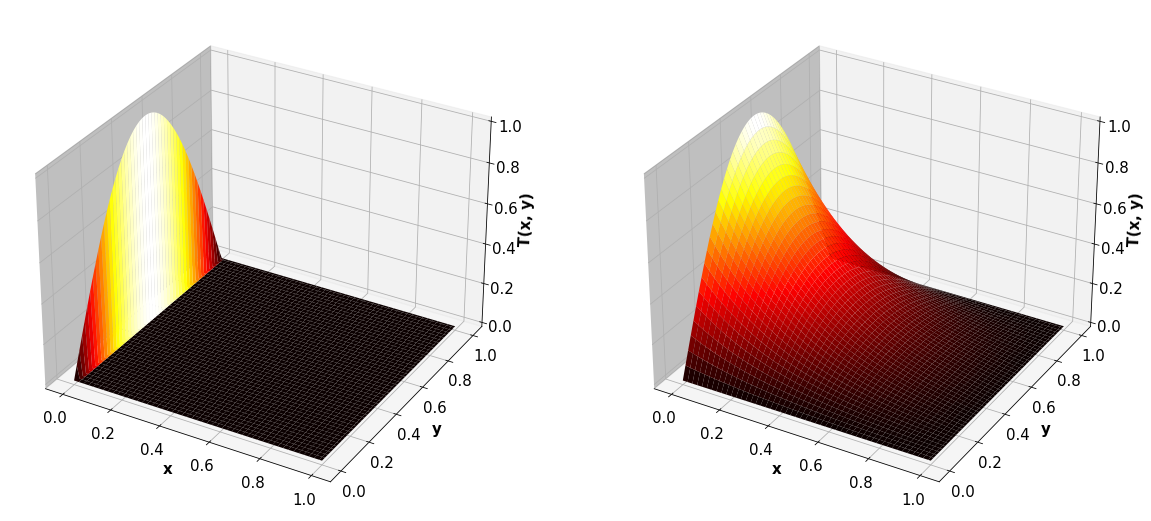

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [5]:
data = generate_data(100)
plot_initial_and_final_temperatures(data, jacobi_solver)

### Benchmarking

The below code runs the solver for various problem sizes (number of grid points), and prints the time taken per iteration for each.

In [6]:
baseline = run_benchmark(jacobi_solver, name="NumPy")
baseline.map(format_time).to_frame()

,NumPy
Grid points per dimension,
500,783.5624339058995 µs
1000,3.1832267800346012 ms
1500,11.439273790456355 ms
2000,20.493918196298182 ms


## Implementation using Cython and C++ standard library algorithms

The Jacobi method can be implemented in terms of the C++ standard library algorithms `std::for_each` for doing the update, and `std::any_of` for checking for convergence.

In [7]:
%%writefile jacobi_serial.pyx

# distutils: language=c++
# cython: cdivision=True

from libcpp.algorithm cimport any_of, for_each, swap, copy
from libcpp.vector cimport vector
from libcpp.functional cimport function
from libcpp cimport bool, float

from jacobi_ops cimport avg, converged


def jacobi_solver(float[:, :] data, float max_diff, int max_iter=10_000):
    M, N  = data.shape[0], data.shape[1]
    
    cdef vector[float] temp
    temp.resize(M*N)
    
    cdef vector[int] indices = range(N+1, (M-1)*N-1)
    
    copy(&data[0, 0], &data[-1, -1], temp.begin())
    
    cdef int iterations = 0
    cdef float* T1 = &data[0, 0]
    cdef float* T2 = temp.data()

    keep_going = True
    while keep_going and iterations < max_iter:
        iterations += 1
        for_each(indices.begin(), indices.end(), avg(T1, T2, M, N))
        keep_going = any_of(indices.begin(), indices.end(), converged(T1, T2, max_diff))
        swap(T1, T2)

    if (T2 == &data[0, 0]):
        copy(temp.begin(), temp.end(), &data[0, 0])

    return iterations


Overwriting jacobi_serial.pyx


<div class="alert alert-info" role="alert">
 
<b>Note:</b> An important detail in the implementation above are the objects of type <code>avg</code> and <code>converged</code>. These <a href="https://en.cppreference.com/w/cpp/utility/functional">function objects</a> or <i>functors</i> define the update and convergence checking operations respectively. Functors, like functions, are callable objects, but they can have state associated with them. They are defined as classes that overload the <code>()</code> or "call" operator. See <code>jacobi_ops.pxd</code> below for examples of how to define them in Cython.
     
</div>

In [8]:
%%writefile jacobi_ops.pxd

# distutils: language=c++
# cython: cdivision=True

from libcpp cimport bool, float
from libc.math cimport fabs

cdef cppclass avg:
    float *T1
    float *T2
    int M, N

    avg(float* T1, float *T2, int M, int N):
        this.T1, this.T2, this.M, this.N = T1, T2, M, N
        
    inline void call "operator()"(int i):
        if (i % this.N != 0 and i % this.N != this.N-1):
            this.T2[i] = (
                this.T1[i-this.N] + this.T1[i+this.N] + this.T1[i-1] + this.T1[i+1]
            ) / 4.0

cdef cppclass converged:
    float *T1
    float *T2
    float max_diff
    
    converged(float* T1, float *T2, float max_diff):
        this.T1, this.T2, this.max_diff = T1, T2, max_diff
        
    inline bool call "operator()"(int i):
        return fabs(this.T2[i] - this.T1[i]) > this.max_diff

Overwriting jacobi_ops.pxd


### Benchmarking

Let's build the extension and benchmark the implementation. Comment out the `%%capture` line to see the output from the compilation and/or to debug any issues.

In [9]:
%%capture
!python setup.py build_ext --inplace

In [10]:
from jacobi_serial import jacobi_solver as jacobi_solver

cpu_serial = run_benchmark(jacobi_solver, name="CPU serial")
cpu_serial.map(format_time).to_frame()

,CPU serial
Grid points per dimension,
500,1.3251253953203557 ms
1000,4.573245354928076 ms
1500,9.739785470999777 ms
2000,16.85156088974327 ms


## Parallelizing on the CPU

As we did in the sorting example, we parallelize the implementation simply by passing the `par` execution policy to the standard library algorithms, and linking the `tbb` library.

In [11]:
%%writefile jacobi_parallel.pyx

# distutils: language=c++
# distutils: libraries=tbb
# cython: cdivision=True

from libcpp.algorithm cimport swap, copy
from libcpp.vector cimport vector
from libcpp.functional cimport function
from libcpp cimport bool, float

from algorithm cimport for_each, any_of
from execution cimport par
from jacobi_ops cimport avg, converged


def jacobi_solver(float[:, :] data, float max_diff, int max_iter=10_000):
    M, N  = data.shape[0], data.shape[1]
    
    cdef vector[float] temp
    temp.resize(M*N)
    
    cdef vector[int] indices = range(N+1, (M-1)*N-1)
    
    copy(&data[0, 0], &data[-1, -1], temp.begin())
    
    cdef int iterations = 0
    cdef float* T1 = &data[0, 0]
    cdef float* T2 = temp.data()

    keep_going = True
    while keep_going and iterations < max_iter:
        iterations += 1
        for_each(par, indices.begin(), indices.end(), avg(T1, T2, M, N))
        keep_going = any_of(par, indices.begin(), indices.end(), converged(T1, T2, max_diff))
        swap(T1, T2)

    if (T2 == &data[0, 0]):
        copy(temp.begin(), temp.end(), &data[0, 0])

    return iterations


Overwriting jacobi_parallel.pyx


### Benchmarking

In [12]:
%%capture
!python setup.py build_ext --inplace

In [13]:
from jacobi_parallel import jacobi_solver as jacobi_solver

cpu_parallel = run_benchmark(jacobi_solver, "CPU parallel")
cpu_parallel.map(format_time).to_frame()

,CPU parallel
Grid points per dimension,
500,240.65955542027953 µs
1000,783.938598819077 µs
1500,1.6857213452458382 ms
2000,2.892688960768282 ms


## GPU implementation using `stdpar`

For GPU execution with `stdpar`, the only additional change required is to manage a local copy of the input data:

In [14]:
%%writefile jacobi_stdpar.pyx

# distutils: language=c++
# cython: cdivision=True

from libcpp.algorithm cimport swap
from libcpp.vector cimport vector
from libcpp.functional cimport function
from libcpp cimport bool, float

from algorithm cimport for_each, any_of, copy
from execution cimport par, seq
from jacobi_ops cimport avg, converged


def jacobi_solver(float[:, :] data, float max_diff, int max_iter=10_000):
    M, N  = data.shape[0], data.shape[1]
    
    cdef vector[float] local
    cdef vector[float] temp
    
    local.resize(M*N)
    temp.resize(M*N)
    
    cdef vector[int] indices = range(N+1, (M-1)*N-1)
    
    copy(seq, &data[0, 0], &data[-1, -1], local.begin())
    copy(par, local.begin(), local.end(), temp.begin())
    
    cdef int iterations = 0
    cdef float* T1 = local.data()
    cdef float* T2 = temp.data()

    keep_going = True
    while keep_going and iterations < max_iter:
        iterations += 1
        for_each(par, indices.begin(), indices.end(), avg(T1, T2, M, N))
        keep_going = any_of(par, indices.begin(), indices.end(), converged(T1, T2, max_diff))
        swap(T1, T2)

    if (T2 == local.data()):
        copy(seq, local.begin(), local.end(), &data[0, 0])
    else:
        copy(seq, temp.begin(), temp.end(), &data[0, 0])

    return iterations


Overwriting jacobi_stdpar.pyx


### Benchmarking

We use `nvc++` to build the extension:

In [ ]:
%%capture
!CC=nvc++ python setup.py build_ext --inplace

In [ ]:
from jacobi_stdpar import jacobi_solver as jacobi_solver

gpu_stdpar = run_benchmark(jacobi_solver, "GPU (nvc++ with -stdpar)")
gpu_stdpar.map(format_time).to_frame()

## Comparing performance

Finally, we plot the speedups over the baseline implementation:

In [ ]:
all_times = pd.DataFrame([baseline, cpu_serial, cpu_parallel, gpu_stdpar]).T
speedups = (1/all_times).multiply(baseline, axis=0)
all_times.applymap(format_time)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
speedups.iloc[:, 1:].plot(
    kind="bar", 
    xlabel="Number of grid points", 
    ylabel="Speedup", 
    figsize=(10, 5),
    grid=True
)

sizes = all_times.index
plt.xticks(range(len(sizes)), [f"${x}^2$" for x in sizes], rotation=0)
plt.savefig("jacobi.png")